In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utils
from altair import Chart
plt.style.use('seaborn')

In [2]:
responses = utils.read_responses('557-responses.csv.zip')
responses.columns

Index(['alg_label', 'network_delay', 'participant_uid', 'response_time',
       'target', 'target_id', 'target_reward', 'timestamp_query_generated'],
      dtype='object')

## Response time 
How long does the average user wait? That data is recorded in the responses and we can plot a histogram. 

We know that waiting for something to happen is characterized by an [exponential random variable]. Can we fit the PDF of an exponential random variable to the reponse time we see? 

[exponential random variable]:https://en.wikipedia.org/wiki/Exponential_distribution

In [3]:
most_responses = (responses['response_time'] >= 0) & (responses['response_time'] <= 15) 
df = responses[most_responses].copy()

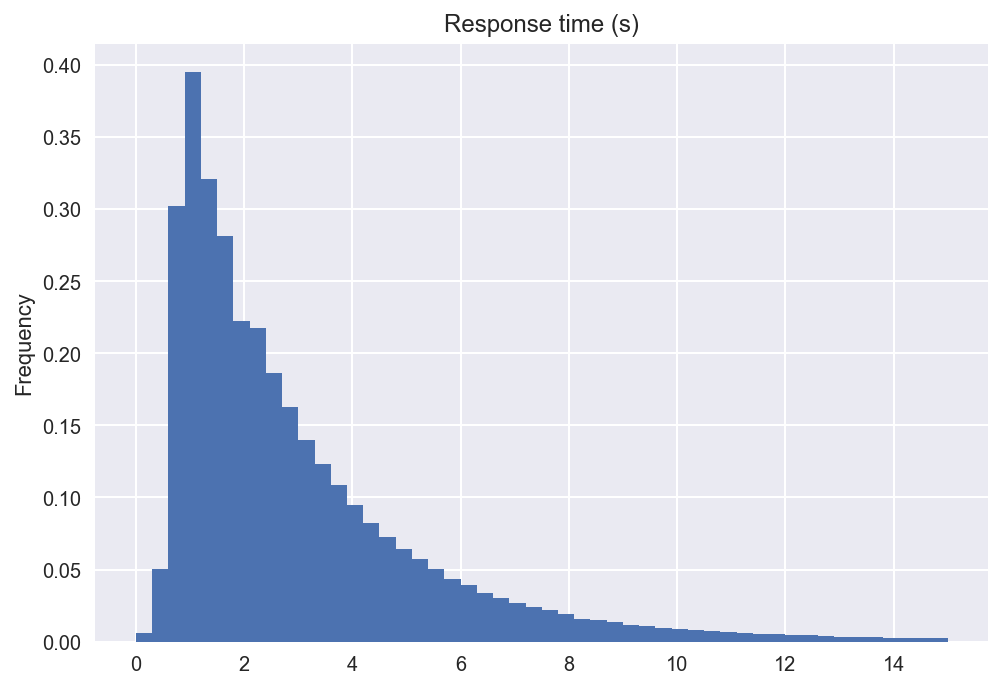

In [4]:
df['response_time'].plot.hist(bins=50, normed=True)
plt.title('Response time (s)')
plt.show()

## Concurrent users
How many users hit our system in a one second period?

In [5]:
import datetime
df = responses.copy()
contest_start = df['timestamp_query_generated'].min()
contest_end = df['timestamp_query_generated'].max()
df = df.sort_values(by='timestamp_query_generated')
delta = datetime.timedelta(seconds=1)
df['seconds_elapsed'] = df['timestamp_query_generated'] - contest_start
df['seconds_elapsed'] = df.apply(lambda row: row['seconds_elapsed'].total_seconds(), axis=1)

In [6]:
total_seconds = (contest_end - contest_start).total_seconds()

In [7]:
def find_users_in_range(start, end):
    if start % 1000 == 0:
        print(start)
    n_questions = (times >= start) & (times < end)
    return {'questions served': n_questions.sum(), 'start': start, 'end': end}

from joblib import Parallel, delayed

times = df['seconds_elapsed'].values
stats = Parallel(n_jobs=-1)(delayed(find_users_in_range)(offset, offset + 60)
                   for offset in range(int(total_seconds)))
print(stats[:3])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [11]:
stats = pd.DataFrame(stats)

In [12]:
max_questions_per_minute = stats['questions served'].max()
print(f'Questions served per minute: {max_questions_per_minute}')

Questions served per minute: 2113


## Network delay
How long does our system take to respond?

In [13]:
most_delays = (responses['network_delay'] >= 0) & (responses['network_delay'] <= 2)
df = responses[most_delays]

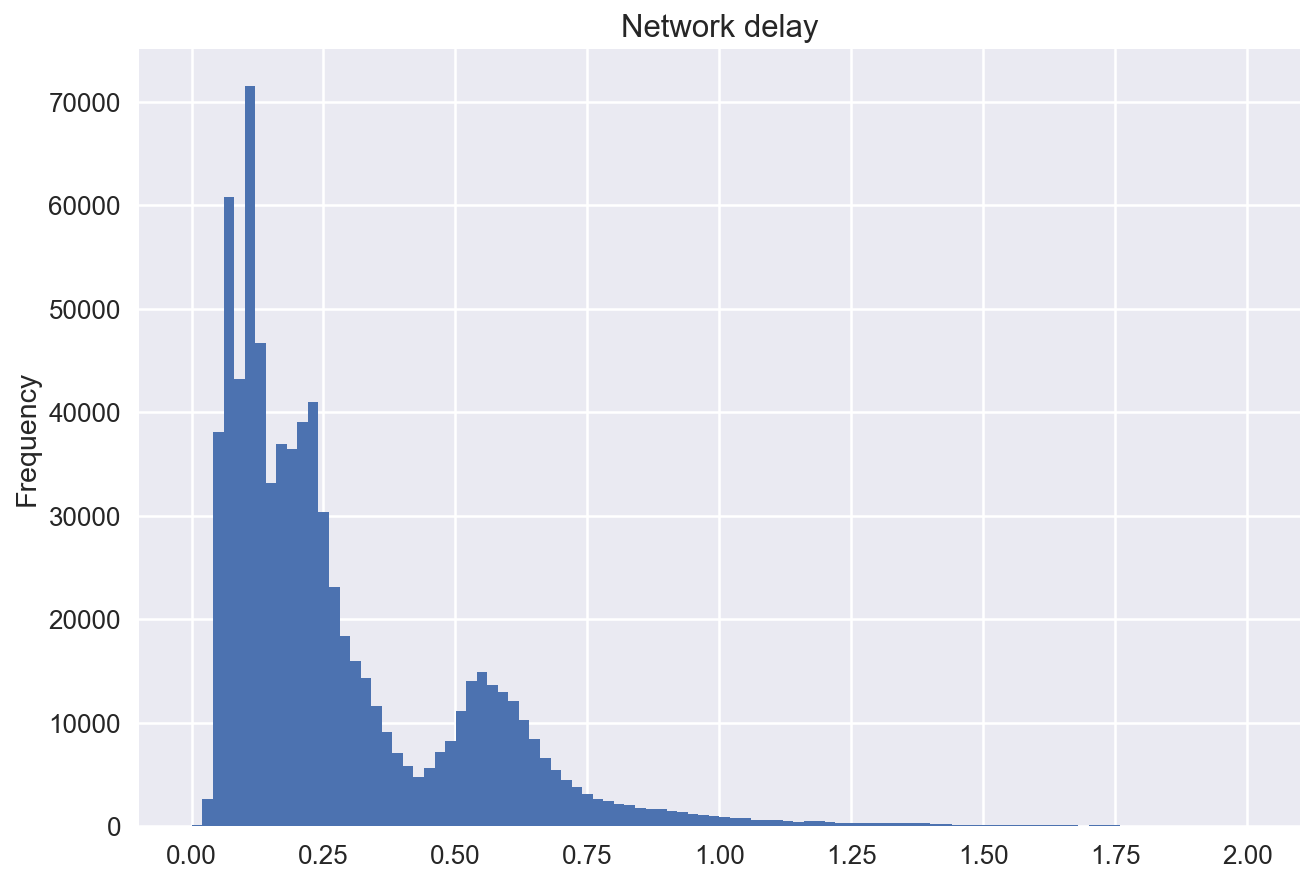

In [16]:
plt.style.use('seaborn-talk')
df['network_delay'].plot.hist(bins=100)
plt.title('Network delay')
plt.show()